In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
import plotly.io as pio
from plotly import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go  
import pandas as pd
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, normalize
import os,sys
import kaleido
sys.path.insert(0,'../scripts/')

from process import *

loading data

In [109]:
df = pd.read_csv("telecom2.csv", na_values=['?',"n.a.","NA","n/a", "na", None])
df.drop("Unnamed: 0",axis=1,inplace=True)

df.head(5)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352",4/4/2019 12:01,770,4/25/2019 14:35,662,"1,823,652","208,201,448,079,117","33,664,962,239","35,521,209,507,511",9.16456699548519E+015,...,"15,854,611","2,501,332","8,198,936","9,656,251","278,082,303","14,344,150","171,744,450","8,814,393","36,749,741","308,879,636"
1,"13,114,483,482,878,900,224",4/9/2019 13:04,235,4/25/2019 8:15,606,"1,365,104","208,201,909,211,140","33,681,854,413","35,794,009,006,359",L77566A,...,"20,247,395","19,111,729","18,338,413","17,227,132","608,750,074","1,170,709","526,904,238","15,055,145","53,800,391","653,384,965"
2,"13,114,483,484,080,500,736",4/9/2019 17:42,1,4/25/2019 11:58,652,"1,361,762","208,200,314,458,056","33,760,627,129","35,281,510,359,387",D42335A,...,"19,725,661","14,699,576","17,587,794","6,163,408","229,584,621","395,630","410,692,588","4,215,763","27,883,638","279,807,335"
3,"13,114,483,485,442,799,616",4/10/2019 0:31,486,4/25/2019 7:36,171,"1,321,509","208,201,402,342,131","33,750,343,200","35,356,610,164,913",T21824A,...,"21,388,122","15,146,643","13,994,646","1,097,942","799,538,153","10,849,722","749,039,933","12,797,283","43,324,218","846,028,530"
4,"13,114,483,499,480,700,928",4/12/2019 20:10,565,4/25/2019 10:40,954,"1,089,009","208,201,401,415,120","33,699,795,932","35,407,009,745,539",D88865A,...,"15,259,380","18,962,873","17,124,581","415,218","527,707,248","3,529,801","550,709,500","13,910,322","38,542,814","569,138,589"


sessions frequency


In [104]:


# Group users
users_data = df.groupby('MSISDN/Number')

# Get sessions frequency (count the number of sessions)
users_sessions= users_data['Bearer Id'].count()
users_sessions.head(10)



MSISDN/Number
33,601,001,722    1
33,601,001,754    1
33,601,002,511    1
33,601,007,832    1
33,601,008,617    2
33,601,010,682    2
33,601,011,634    2
33,601,011,959    1
33,601,014,694    2
33,601,020,306    1
Name: Bearer Id, dtype: int64

the duration of the session 


In [105]:
# How long each session was
users_sessions= users_data['Dur. (ms)'].sum()
users_sessions

MSISDN/Number
33,601,001,722        116,720
33,601,001,754        181,230
33,601,002,511        134,969
33,601,007,832         49,878
33,601,008,617         37,104
                        ...  
33,789,996,170          8,810
33,789,997,247        140,988
3,197,020,876,596     877,385
337,000,037,000,919   253,030
882,397,108,489,451   869,844
Name: Dur. (ms), Length: 106471, dtype: float64

In [106]:
# Aggregation of Total values
df["Total Uploads"]=df["Google UL (Bytes)"]+df["Email UL (Bytes)"]+df["Social Media UL (Bytes)"]+df["Youtube UL (Bytes)"]+df["Netflix UL (Bytes)"]+df["Gaming UL (Bytes)"]+df["Other UL (Bytes)"]
df["Total Downloads"]=df["Google DL (Bytes)"]+df["Email DL (Bytes)"]+df["Social Media DL (Bytes)"]+df["Youtube DL (Bytes)"]+df["Netflix DL (Bytes)"]+df["Gaming DL (Bytes)"]+df["Other DL (Bytes)"]
df['Total UL and DL']=df['Total DL (Bytes)']+df["Total UL (Bytes)"]



# Aggregation of Total Social Media data
df["Youtube_Total_Data"]=df["Youtube DL (Bytes)"]+df["Youtube UL (Bytes)"]
df["Google_Total_Data"]=df["Google DL (Bytes)"]+df["Google UL (Bytes)"]
df["Email_Total_Data"]=df["Email DL (Bytes)"]+df["Email UL (Bytes)"]
df["Social_Media_Total_Data"]=df["Social Media DL (Bytes)"]+df["Social Media UL (Bytes)"]
df["Netflix_Total_Data"]=df["Netflix DL (Bytes)"]+df["Netflix UL (Bytes)"]
df["Gaming_Total_Data"]=df["Gaming DL (Bytes)"]+df["Gaming UL (Bytes)"]
df["Other_Total_Data"]=df["Other DL (Bytes)"]+df["Other UL (Bytes)"]


the sessions total traffic (download and upload (bytes))

In [107]:
users = df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms).1', 'Total UL and DL']].copy().rename(columns={'Dur. (ms).1': 'time_duration'})
users


,MSISDN/Number,Bearer Id,time_duration,Total UL and DL
0,"33,664,962,239","13,114,483,460,844,900,352","1,823,652,892","345,629,377"
1,"33,681,854,413","13,114,483,482,878,900,224","1,365,104,371","707,185,356"
2,"33,760,627,129","13,114,483,484,080,500,736","1,361,762,651","307,690,973"
3,"33,750,343,200","13,114,483,485,442,799,616","1,321,509,685","889,352,748"
4,"33,699,795,932","13,114,483,499,480,700,928","1,089,009,389","607,681,403"
...,...,...,...,...
148501,"33,668,648,496","13,042,425,979,329,300,480","59,587,792","872,761,860"
148502,"33,650,688,697","7,277,825,670,196,679,680","81,230,763","631,804,110"
148503,"33,663,449,963","7,349,883,264,234,609,664","97,970,704","705,783,925"
148504,"33,621,890,103","13,114,483,573,367,300,096","98,249,527","627,698,629"


In [55]:
users = users.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'time_duration': 'sum', 'Total UL and DL': 'sum'})
users = users.rename(columns={'Bearer Id': 'sessions'})
users.head(10)

,sessions,time_duration,Total UL and DL
MSISDN/Number,,,
"33,601,001,722",1,"116,720,140","878,690,574"
"33,601,001,754",1,"181,230,963","156,859,643"
"33,601,002,511",1,"134,969,374","595,966,483"
"33,601,007,832",1,"49,878,024","422,320,698"
"33,601,008,617",2,"37,104,453","1,457,410,944"
"33,601,010,682",2,"253,983,077","615,217,221"
"33,601,011,634",2,"128,360,523","654,723,066"
"33,601,011,959",1,"86,399,977","332,660,357"
"33,601,014,694",2,"495,702,147","990,132,189"


Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric


Top 10 user Engagements to time

In [56]:
users.nlargest(10, 'time_duration')


,sessions,time_duration,Total UL and DL
MSISDN/Number,,,
"33,625,779,332",17,"18,553,763,486","8,499,620,722"
"33,614,892,860",17,"9,966,905,758","8,846,226,494"
"33,760,536,639",15,"9,279,442,000","8,514,773,963"
"33,626,320,676",18,"8,791,936,680","7,971,167,261"
"33,667,163,239",13,"8,744,922,020","5,618,394,054"
"33,662,840,755",9,"6,614,274,287","4,000,097,981"
"33,664,693,736",9,"6,288,735,771","5,682,007,334"
"33,603,127,838",12,"6,287,767,483","4,976,195,043"
"33,667,456,716",6,"5,649,885,358","2,600,521,941"



Top 10 user Engagements to time

In [57]:
users.nlargest(10, 'time_duration')


,sessions,time_duration,Total UL and DL
MSISDN/Number,,,
"33,625,779,332",17,"18,553,763,486","8,499,620,722"
"33,614,892,860",17,"9,966,905,758","8,846,226,494"
"33,760,536,639",15,"9,279,442,000","8,514,773,963"
"33,626,320,676",18,"8,791,936,680","7,971,167,261"
"33,667,163,239",13,"8,744,922,020","5,618,394,054"
"33,662,840,755",9,"6,614,274,287","4,000,097,981"
"33,664,693,736",9,"6,288,735,771","5,682,007,334"
"33,603,127,838",12,"6,287,767,483","4,976,195,043"
"33,667,456,716",6,"5,649,885,358","2,600,521,941"


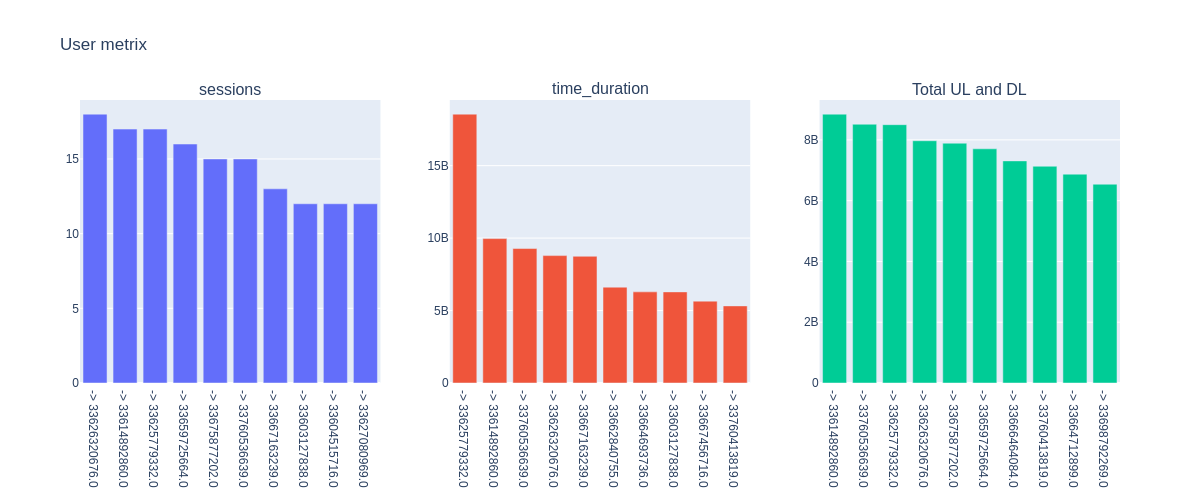

In [61]:
sessions = users.nlargest(10, "sessions")['sessions']
duration = users.nlargest(10, "time_duration")['time_duration']
data_volume = users.nlargest(10, "Total UL and DL")['Total UL and DL']

mult_hist([sessions, duration, data_volume], 1,3, "User metrix", ['sessions', 'time_duration','Total UL and DL'])

Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement.

<Axes: >

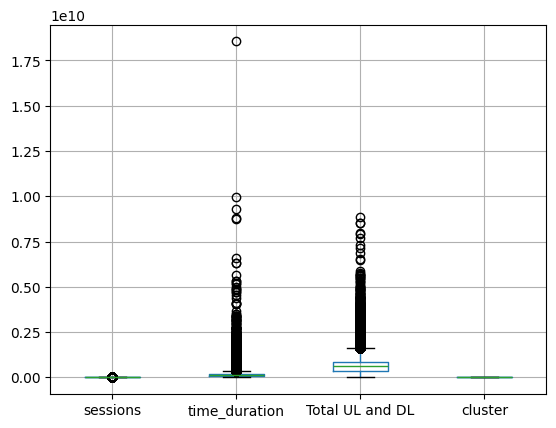

In [101]:
users.boxplot()

In [ ]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(users)
pd.DataFrame(scaled_array).head(5)


,0,1,2
0,-0,-0,0
1,-0,0,-1
2,-0,-0,-0
3,-0,-1,-1
4,1,-1,2


In [99]:

data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

data_normalized

array([[-0.76408895, -0.24991032,  0.59473768],
       [-0.4052939 ,  0.15390326, -0.90113852],
       [-0.92290056, -0.11732369, -0.3667284 ],
       ...,
       [-0.12059375,  0.96559804, -0.23038569],
       [-0.63027829,  0.73514963, -0.24960829],
       [-0.12032247,  0.95348454, -0.27638691]])

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

/home/brook/.local/share/virtualenvs/brook-XTTTytiq/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([2, 1, 1, ..., 0, 1, 0], dtype=int32)

In [ ]:
users.insert(0, 'Cluster', kmeans.labels_)
users.head(5)

,Cluster,sessions,time_duration,Total UL and DL
MSISDN/Number,,,,
"33,601,001,722",2,1,"116,720,140","878,690,574"
"33,601,001,754",1,1,"181,230,963","156,859,643"
"33,601,002,511",1,1,"134,969,374","595,966,483"
"33,601,007,832",1,1,"49,878,024","422,320,698"
"33,601,008,617",0,2,"37,104,453","1,457,410,944"


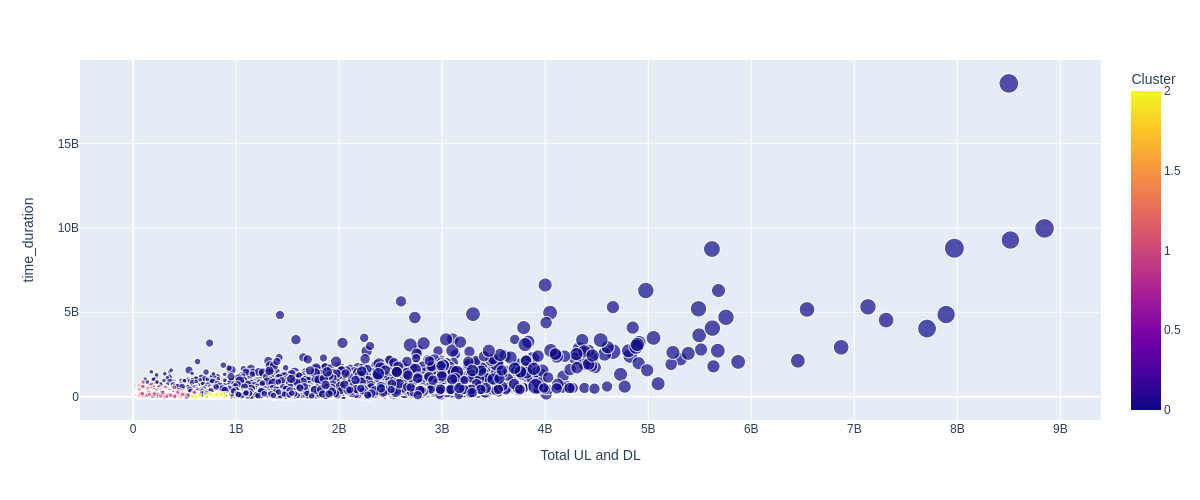

In [ ]:
fig = px.scatter(users, x='Total UL and DL', y="time_duration", color='Cluster', size='sessions')
Image(pio.to_image(fig, format='png', width=1200))



Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.



In [ ]:
cluster1 = users[users["Cluster"]==0]
cluster1.describe()

,Cluster,sessions,time_duration,Total UL and DL
count,"29,255","29,255","29,255","29,255"
mean,0,2,"265,495,741","1,209,877,109"
std,0,1,"309,472,480","592,993,584"
min,0,1,"18,235,797","118,487,293"
25%,0,2,"131,062,640","822,497,902"
50%,0,2,"202,420,249","1,108,077,989"
75%,0,3,"326,199,036","1,463,461,761"
max,0,18,"18,553,763,486","8,846,226,494"


In [ ]:
cluster1 = users[users["Cluster"]==1]
cluster1.describe()

,Cluster,sessions,time_duration,Total UL and DL
count,"47,731","47,731","47,731","47,731"
mean,1,1,"106,580,786","334,891,880"
std,0,0,"70,023,531","152,639,106"
min,1,1,"7,189,000","33,249,009"
25%,1,1,"59,829,364","204,335,092"
50%,1,1,"87,516,830","332,846,651"
75%,1,1,"142,797,239","464,937,876"
max,1,2,"869,830,549","697,705,378"


Aggregate user total traffic per application and derive the top 10 most engaged users per application



In [ ]:
apps_df = df.groupby('MSISDN/Number').agg({'Gaming_Total_Data': 'sum', 'Youtube_Total_Data': 'sum', 'Netflix_Total_Data': 'sum',\
                     'Google_Total_Data': 'sum', 'Email_Total_Data': 'sum', 'Social_Media_Total_Data': 'sum', 'Other_Total_Data': 'sum'})
apps_df.head(10)

,Gaming_Total_Data,Youtube_Total_Data,Netflix_Total_Data,Google_Total_Data,Email_Total_Data,Social_Media_Total_Data,Other_Total_Data
MSISDN/Number,,,,,,,
"33,601,001,722","812,458,661","21,624,548","27,180,981","4,389,005","1,331,362","2,232,135","386,570,872"
"33,601,001,754","119,750,078","12,432,223","11,221,763","5,334,863","3,307,781","2,660,565","281,710,071"
"33,601,002,511","538,827,713","21,333,570","19,353,900","3,443,126","3,205,380","3,195,623","501,693,672"
"33,601,007,832","391,126,127","6,977,321","1,942,092","9,678,493","2,284,670","280,294","35,279,702"
"33,601,008,617","1,314,797,820","41,533,002","49,201,724","18,499,616","3,305,469","2,912,542","804,804,484"
"33,601,010,682","511,635,787","34,347,122","30,315,501","15,263,134","7,848,596","3,792,912","492,372,777"
"33,601,011,634","548,461,057","26,431,335","45,812,397","10,196,403","1,358,959","2,769,627","224,888,713"
"33,601,011,959","282,364,397","18,892,740","15,292,840","12,023,614","2,215,563","1,782,692","178,201,537"
"33,601,014,694","833,087,952","63,443,802","54,216,117","14,134,211","4,599,825","5,288,685","1,041,882,992"


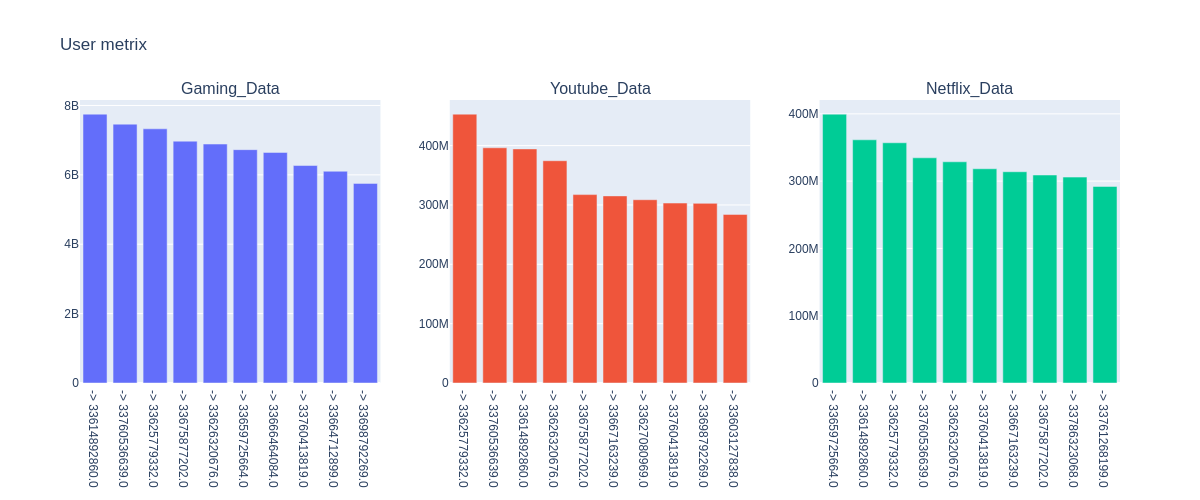

In [ ]:
Gaming_Data = apps_df.nlargest(10, "Gaming_Total_Data")['Gaming_Total_Data']
Youtube_Data = apps_df.nlargest(10, "Youtube_Total_Data")['Youtube_Total_Data']
Netflix_Data = apps_df.nlargest(10, "Netflix_Total_Data")['Netflix_Total_Data']
Google_Data = apps_df.nlargest(10, "Google_Total_Data")['Google_Total_Data']
Email_Data = apps_df.nlargest(10, "Email_Total_Data")['Email_Total_Data']
Social_Media = apps_df.nlargest(10, "Social_Media_Total_Data")['Social_Media_Total_Data']
Other_Data = apps_df.nlargest(10, "Other_Total_Data")['Other_Total_Data']


mult_hist([Gaming_Data, Youtube_Data, Netflix_Data], 1,
          3, "User metrix", ["Gaming_Data", "Youtube_Data", "Netflix_Data"])



Plot the top 3 most used applications using appropriate charts.

In [ ]:
top_3 = apps_df.sum()
type(top_3)

top_3

Gaming_Total_Data         63,910,124,731,666
Youtube_Total_Data         3,362,537,620,065
Netflix_Total_Data         3,360,563,670,772
Google_Total_Data          1,159,544,186,717
Email_Total_Data             335,503,000,148
Social_Media_Total_Data      271,478,798,103
Other_Total_Data          63,770,726,326,023
dtype: float64

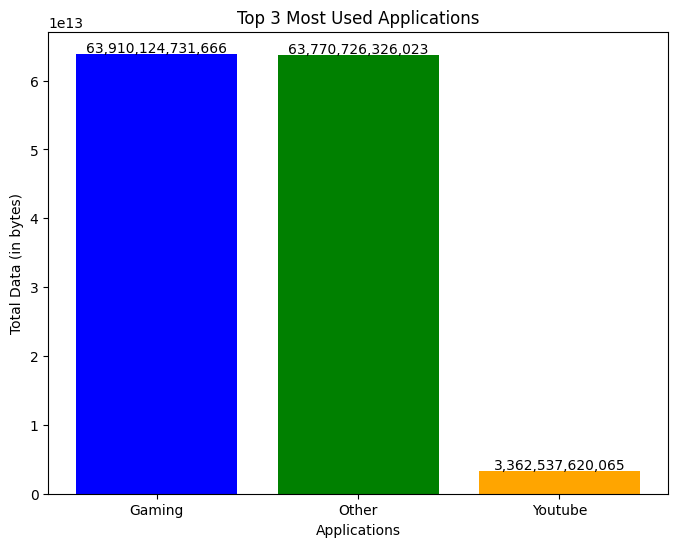

In [ ]:
import matplotlib.pyplot as plt

# Data
applications = ['Gaming', 'Youtube', 'Netflix', 'Google', 'Email', 'Social Media', 'Other']
data_values = [63910124731666, 3362537620065, 3360563670772, 1159544186717, 335503000148, 271478798103, 63770726326023]

# Sorting the data in descending order
sorted_data = sorted(zip(applications, data_values), key=lambda x: x[1], reverse=True)

# Extracting top 3
top_applications = [app for app, _ in sorted_data[:3]]
top_values = [value for _, value in sorted_data[:3]]

# Setting a smaller figure size
plt.figure(figsize=(8, 6))

# Plotting
plt.bar(top_applications, top_values, color=['blue', 'green', 'orange'])
plt.title('Top 3 Most Used Applications')
plt.xlabel('Applications')
plt.ylabel('Total Data (in bytes)')

# Display the values on top of the bars
for i, value in enumerate(top_values):
    plt.text(i, value + 0.002 * max(top_values), f'{value:,}', ha='center')

# Show the plot
plt.show()


Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: What is the optimized value of k (use elbow method for this)?
Interpret your findings.
*Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics.
What is the optimized value of k (use elbow method for this)?
Interpret your findings.

Distortion- is the average of the euclidean squared distance from the centroid of the respective clusters.

Inertia- is the sum of squared distances of samples to their closest cluster 
    centre.



In [96]:
def choose_kmeans(df: pd.DataFrame, num: int):
  distortions = []
  inertias = []
  K = range(1, num)
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
    distortions.append(sum(
        np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeans.inertia_)

  return (distortions, inertias)


In [97]:
distortions, inertias = choose_kmeans(data_normalized, 1)

In [ ]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method")
# fig.show(config=config)
Image(pio.to_image(fig, format='png', width=1200))



Four cluster value is optimal number of cluster


In [82]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_normalized)
users["cluster"]= kmeans.labels_
users

/home/brook/.local/share/virtualenvs/brook-XTTTytiq/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,sessions,time_duration,Total UL and DL,cluster
MSISDN/Number,,,,
"33,601,001,722",1,"116,720,140","878,690,574",1
"33,601,001,754",1,"181,230,963","156,859,643",2
"33,601,002,511",1,"134,969,374","595,966,483",2
"33,601,007,832",1,"49,878,024","422,320,698",2
"33,601,008,617",2,"37,104,453","1,457,410,944",0
...,...,...,...,...
"33,789,996,170",1,"8,810,688","714,641,641",1
"33,789,997,247",1,"140,988,659","480,307,335",2
"3,197,020,876,596",1,"877,385,325","232,123,971",3
